# Distribuciones categórica y multinomial

## Distribución multinomial (categórica con $N=1$)

0.08504999999999999
[[4 2 4]
 [3 0 7]
 [4 3 3]
 [5 0 5]]


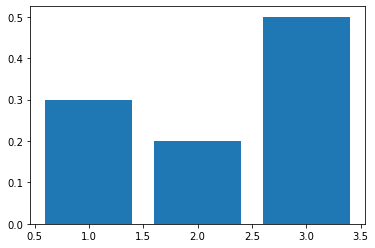

In [1]:
# %load '2.5.1.M.py'
import numpy as np
from scipy.stats import multinomial
import matplotlib.pyplot as plt

N, t = 10, [0.3, 0.2, 0.5]
S = multinomial(N, t)
print(S.pmf([3, 2, 5]))
print(S.rvs(4))
plt.bar(np.arange(1,len(t)+1), S.p)
plt.show()


## Función softmax

La softmax transforma transforma logits $\boldsymbol{a}\in\mathbb{R}^C$ en un vector de probabilidades $[0,1]^C$:
$$\mathcal{S}(\boldsymbol{a})=\left[%
\frac{e^{a_1}}{\sum_{\tilde{c}}e^{a_{\tilde{c}}}},\dotsc,%
\frac{e^{a_C}}{\sum_{\tilde{c}}e^{a_{\tilde{c}}}}\right]%
\qquad\text{cumpliéndose}\qquad%
0\leq\mathcal{S}(\boldsymbol{a})_c\leq 1%
\quad\text{y}\quad%
\sum_{c=1}^C \mathcal{S}(\boldsymbol{a})_c=1$$

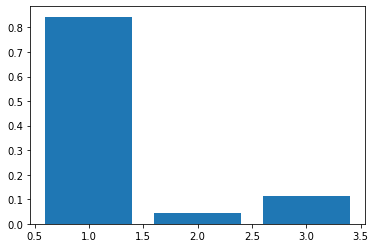

In [2]:
# %load '2.5.2.softmax.py'
import numpy as np
import matplotlib.pyplot as plt

def softmax(a):
	e = np.exp((1.0 * np.array(a)))
	return e / np.sum(e)

a = np.array([3, 0, 1])
plt.bar(np.arange(1,a.size+1), softmax(a))
plt.show()


La softmax se emplea para predecir el vector de probabilidades de una categórica (o multinomial) condicional,
$$p(\boldsymbol{y}\mid\boldsymbol{x},\boldsymbol{\theta})%
=\operatorname{Cat}(\boldsymbol{y}\mid f(\boldsymbol{x};\boldsymbol{\theta}))%
=\mathcal{M}(\boldsymbol{y}\mid 1,f(\boldsymbol{x};\boldsymbol{\theta})),$$
mediante un predictor no normalizado del vector de probabilidades;
los logits $\boldsymbol{a}=f(\boldsymbol{x};\boldsymbol{\theta})$.

La softmax es una versión suavizada de la argmax. Si dividimos los logits por una constante de *temperatura* $\,T>0$,
$$\lim_{T\to 0}\;\mathcal{S}(\boldsymbol{a}/T)_c=\begin{cases}
    1.0 & \text{si $c=\operatorname{argmax}_{c'}a_{c'}$}\\%
    0.0 & \text{en otro caso}%
\end{cases}
$$
mientras que, a altas temperaturas, se aproxima a la uniforme.

## Función log-sum-exp

La log-sum-exp calcula de manera robusta el logaritmo de la suma de logits $\boldsymbol{a}\in\mathbb{R}^C$:
$$\operatorname{lse}(\boldsymbol{a})%
=\log\sum_{c=1}^C \exp(a_c)%
=\max_{c'} a_{c'}+\log\sum_{c=1}^C \exp(a_c-\max_{c'} a_{c'})$$

In [3]:
# %load '2.5.4.logsumexp.py'
import numpy as np
from scipy.special import logsumexp

a = 1.0 * np.array([0, 1, 0])
print(np.log(np.sum(np.exp(a))), logsumexp(a))

a = 1.0 * np.array([1000, 1001, 1000])
print(np.log(np.sum(np.exp(a))), logsumexp(a))

a = 1.0 * np.array([-1000, -999, -1000])
print(np.log(np.sum(np.exp(a))), logsumexp(a))


1.5514447139320509 1.551444713932051
inf 1001.551444713932
-inf -998.448555286068


/tmp/ipykernel_150522/703808950.py:9: RuntimeWarning: overflow encountered in exp
  print(np.log(np.sum(np.exp(a))), logsumexp(a))
/tmp/ipykernel_150522/703808950.py:12: RuntimeWarning: divide by zero encountered in log
  print(np.log(np.sum(np.exp(a))), logsumexp(a))


La log-sum-exp permite calcular de manera robusta las probabilidades de una categórica (o multinomial) a partir de los logits,
$$p(y=c\mid\boldsymbol{x})%
=\frac{\exp(a_c)}{\sum_{c'=1}^C \exp(a_{c'})}%
=\exp\left(\log(\exp(a_c))-\log\sum_{c'=1}^C \exp(a_{c'})\right)%
=\exp(a_c-\operatorname{lse}(\boldsymbol{a}))$$

## Regresión logística multinomial

Regresión logística multinomial es una categórica condicional para clasificación multiclase,
$$p(\boldsymbol{y}\mid\boldsymbol{x},\boldsymbol{\theta})%
=\operatorname{Cat}(\boldsymbol{y}\mid f(\boldsymbol{x};\boldsymbol{\theta})),$$
de logits lineales con la entrada,
$$\boldsymbol{a}=f(\boldsymbol{x};\boldsymbol{\theta})=\mathbf{W}\boldsymbol{x}+\boldsymbol{b},%
\quad\mathbf{W}\in\mathbb{R}^{C\times D},\,\boldsymbol{b}\in\mathbb{R}^C$$

**Ejemplo:** $\,D=2,\,\boldsymbol{x}\in[0, 1]^D,\,C=4,%
\,\mathbf{W}=\begin{pmatrix}1 &1\\-1&1\\-1&-1\\1&-1\end{pmatrix},%
\,\boldsymbol{b}=\boldsymbol{0}_C$

In [4]:
x_min = y_min = -1.0
x_max = y_max = 1.0
x, y = np.meshgrid(np.linspace(x_min, x_max, num=1000), np.linspace(y_min, y_max, num=1000))
W = np.array([[1., 1.], [-1., 1.], [-1., -1.], [1., -1.]])
b = np.array([.0, .0, .0, .0])

Cálculo de logits y posteriors:

In [8]:
from scipy.special import logsumexp

C, D = W.shape
X = np.squeeze(np.dstack([np.ravel(x), np.ravel(y)]))
aT1 = X @ W.T + b
T = .01 # temperatura próxima a cero para hallar posteriors cercanos a argmax
a = aT1 / T
p = np.exp(a-logsumexp(a, axis=1).reshape(-1, 1))

Logits por clase:

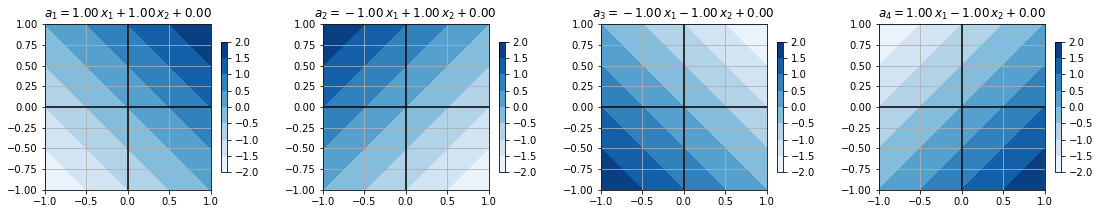

In [6]:
fig, axes = plt.subplots(1, C, figsize=(4*C, 4))
fig.tight_layout(pad=4)
for j in np.arange(0, C):
    ax = axes[j]
    ax.set(aspect='equal', xlim=(x_min, x_max), ylim=(y_min, y_max))
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title('$a_{:}={:.2f}\,x_1{:+.2f}\,x_2{:+.2f}$'.format(j+1, W[j, 0], W[j, 1], b[j]))
    cp = ax.contourf(x, y, aT1[:, j].reshape(x.shape), cmap='Blues')
    plt.colorbar(cp, ax=axes[j], shrink=0.7)

Posteriors por clase con softmax atemperada:

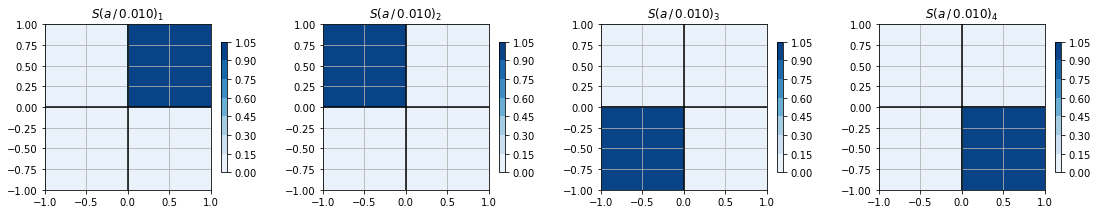

In [7]:
fig, axes = plt.subplots(1, C, figsize=(4*C, 4))
fig.tight_layout(pad=4)
for j in np.arange(0, C):
    ax = axes[j]
    ax.set(aspect='equal', xlim=(x_min, x_max), ylim=(y_min, y_max))
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title('$S(a\,/\,{:.3f})_{:}$'.format(T, j+1))
    cp = ax.contourf(x, y, p[:, j].reshape(x.shape), cmap='Blues')
    plt.colorbar(cp, ax=axes[j], shrink=0.7)